<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Competition/Kaggle/Scrabble%20Player%20Rating/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## Install

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 46.0 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 147 kB 51.4 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 30.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8c29b75e5c2e0cd044fa9e60d5d0e2cf65bc6a758edd0b60be6fd68cab5b06f3
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


## Library

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import os

from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, GroupKFold

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# Load Data Set

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Train / Test Set

In [106]:
X = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/y_train.csv')
y = y['rating']
X_test = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_test.csv')

# Modeling

## Optuna

In [107]:
groups = X.pop('nickname')

def objective(trial, X, y):
    
    # 적용(수색)할 최적의 하이퍼 파라미터 범위 지정
    param = {
        "objective": "regression",
        "verbosity": -1,
        'learing_rate': trial.suggest_float('learing_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 8, 25),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.03, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.03, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 128),
    }
    
    # LGBM reg 모델 사용 / 교차 검증 사용
    folds = GroupKFold(n_splits=5).split(X, y, groups=groups)

    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= folds,
                   verbose_eval=100,                   
                   early_stopping_rounds=100,                   
                   num_boost_round=50000,
                   metrics = 'rmse',
                  )
    
    cv_score = lgbcv['rmse-mean'][-1]
    
    # Return metric of interest
    return cv_score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y),
               timeout=9000,
               n_trials=300,
               n_jobs=1,
               show_progress_bar=True) 

  0%|          | 0/300 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 135.65 + 48.4025
[200]	cv_agg's rmse: 131.403 + 42.8591
[300]	cv_agg's rmse: 129.431 + 39.272
[400]	cv_agg's rmse: 128.184 + 36.266
[500]	cv_agg's rmse: 127.741 + 34.901
[600]	cv_agg's rmse: 127.405 + 33.6483
[700]	cv_agg's rmse: 126.777 + 32.3117
[800]	cv_agg's rmse: 126.546 + 31.3872
[900]	cv_agg's rmse: 125.521 + 29.4887
[1000]	cv_agg's rmse: 125.587 + 28.6932
[100]	cv_agg's rmse: 126.275 + 34.4094
[200]	cv_agg's rmse: 127.849 + 38.095
[100]	cv_agg's rmse: 115.722 + 17.1251
[100]	cv_agg's rmse: 119.954 + 23.2899
[200]	cv_agg's rmse: 119.057 + 23.8464
[100]	cv_agg's rmse: 133.203 + 45.6071
[200]	cv_agg's rmse: 127.606 + 36.5633
[300]	cv_agg's rmse: 125.547 + 33.3174
[400]	cv_agg's rmse: 125.499 + 32.3544
[500]	cv_agg's rmse: 125.124 + 31.2426
[100]	cv_agg's rmse: 114.059 + 8.96145
[100]	cv_agg's rmse: 106.22 + 5.58278
[100]	cv_agg's rmse: 119.523 + 22.4268
[200]	cv_agg's rmse: 118.454 + 19.5025
[300]	cv_agg's rmse: 117.408 + 17.13
[400]	cv_agg's rmse: 117.346 + 1

In [ ]:
print(study.best_params)

In [ ]:
print(study.best_value)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

## Group KFold

In [96]:
preds = []

test_groups = X_test.pop('nickname') 

num_fold = 0

for repeat in range(3):

  skf = GroupKFold(n_splits=5)

  for fold_idx, (train_index, valid_index) in enumerate(tqdm(skf.split(X, y, groups=groups))):
      X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      lgb_params = {
          'objective': 'regression',
          'verbose': 100,
          'n_estimators': 50000,
          **study.best_params
      }

      print(f'\nNumber fold : {num_fold}\n')

      model = LGBMRegressor(**lgb_params)

      model.fit(
                X = X_train, y = y_train,
                eval_set=(X_valid, y_valid),
                eval_metric = 'rmse',
                verbose=100,
                early_stopping_rounds=100
                )

      y_pred = model.predict(X_valid)

      score = mean_squared_error(y_valid, y_pred, squared=False)

      print("\nFold {} MSE Score: {}\n".format(fold_idx, score))
      print("\n----------------------\n")

      preds.append(model.predict(X_test))

      num_fold += 1

0it [00:00, ?it/s]


Number fold : 0

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 135.173	valid_0's l2: 18271.6
[200]	valid_0's rmse: 131.598	valid_0's l2: 17318
Early stopping, best iteration is:
[113]	valid_0's rmse: 130.325	valid_0's l2: 16984.7

Fold 0 MSE Score: 130.3254022183349


----------------------


Number fold : 1

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 106.026	valid_0's l2: 11241.6
[200]	valid_0's rmse: 108.099	valid_0's l2: 11685.3
Early stopping, best iteration is:
[108]	valid_0's rmse: 106.001	valid_0's l2: 11236.3

Fold 1 MSE Score: 106.00138827005728


----------------------


Number fold : 2

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 117.02	valid_0's l2: 13693.7
Early stopping, best iteration is:
[53]	valid_0's rmse: 116.104	valid_0's l2: 13480.1

Fold 2 MSE Score: 116.10370316352113


----------------------


Number fold : 3

Training until validation score

0it [00:00, ?it/s]


Number fold : 5

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 135.173	valid_0's l2: 18271.6
[200]	valid_0's rmse: 131.598	valid_0's l2: 17318
Early stopping, best iteration is:
[113]	valid_0's rmse: 130.325	valid_0's l2: 16984.7

Fold 0 MSE Score: 130.3254022183349


----------------------


Number fold : 6

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 106.026	valid_0's l2: 11241.6
[200]	valid_0's rmse: 108.099	valid_0's l2: 11685.3
Early stopping, best iteration is:
[108]	valid_0's rmse: 106.001	valid_0's l2: 11236.3

Fold 1 MSE Score: 106.00138827005728


----------------------


Number fold : 7

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 117.02	valid_0's l2: 13693.7
Early stopping, best iteration is:
[53]	valid_0's rmse: 116.104	valid_0's l2: 13480.1

Fold 2 MSE Score: 116.10370316352113


----------------------


Number fold : 8

Training until validation score

0it [00:00, ?it/s]


Number fold : 10

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 135.173	valid_0's l2: 18271.6
[200]	valid_0's rmse: 131.598	valid_0's l2: 17318
Early stopping, best iteration is:
[113]	valid_0's rmse: 130.325	valid_0's l2: 16984.7

Fold 0 MSE Score: 130.3254022183349


----------------------


Number fold : 11

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 106.026	valid_0's l2: 11241.6
[200]	valid_0's rmse: 108.099	valid_0's l2: 11685.3
Early stopping, best iteration is:
[108]	valid_0's rmse: 106.001	valid_0's l2: 11236.3

Fold 1 MSE Score: 106.00138827005728


----------------------


Number fold : 12

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 117.02	valid_0's l2: 13693.7
Early stopping, best iteration is:
[53]	valid_0's rmse: 116.104	valid_0's l2: 13480.1

Fold 2 MSE Score: 116.10370316352113


----------------------


Number fold : 13

Training until validation s

# Submission

In [97]:
final_preds = np.mean(preds, axis=0)

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

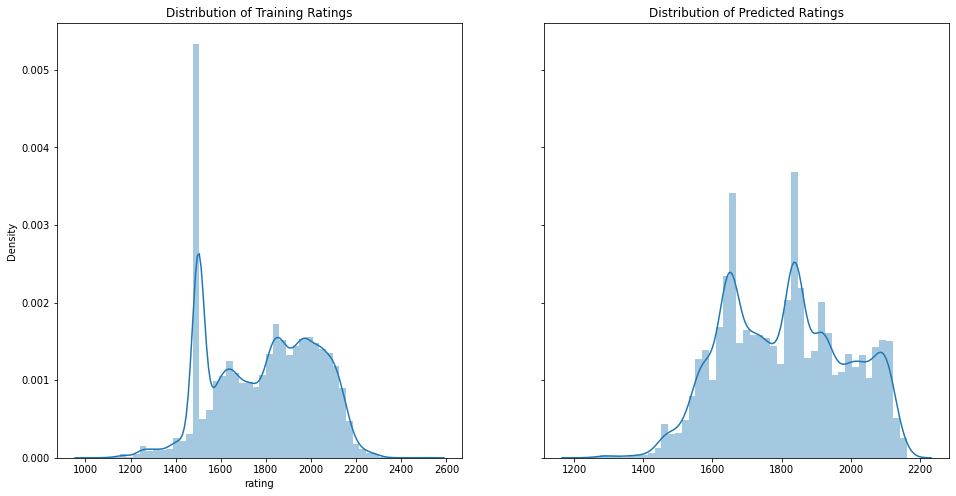

In [98]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(y, ax=axs[0])
axs[0].set_title("Distribution of Training Ratings")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Ratings")

In [99]:
X_test['rating'] = final_preds
submission = X_test[['game_id', 'rating']].set_index('game_id')

path_save = '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/submission/'
submission.to_csv(path_save + "LGBM_1.csv")

In [100]:
submission

,rating
game_id,
2,2000.915688
7,1910.337799
11,1757.550980
14,1850.653332
27,2094.198819
...,...
72760,2079.873386
72761,1690.045648
72762,1582.388225
